# TP 3: Hasting-Metropolis (and Gibbs) samplers

In [1]:
# Imports
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

DEFAULT_ITERATIONS = 500

## Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

In [2]:
# Constant parameters
p0_bar = 1
sigma_p0 = 1
p0 = np.random.normal(p0_bar, sigma_p0)

In [3]:
# The initialization we will use for all estimation algorithms
theta0 = np.array([0.0, 0.0, 1, 1, 1])

### Question 2)

In [4]:
N = 100
k = 20

In [5]:
# Constant parameters
sigma_t0 = 0.1
sigma_v0 = 0.1
s_t0 = 0.1
s_v0 = 0.1
t0_bar_bar = 1
v0_bar_bar = 1
m = 5
m_xi = 5
m_tau = 5
v = 5
v_xi = 5
v_tau = 5

In [6]:
def generate_theta():
    t0_bar = np.random.normal(t0_bar_bar, s_t0)
    v0_bar = np.random.normal(v0_bar_bar, s_v0)
    sigma_xi = np.sqrt(1 / np.random.gamma(m_xi, v_xi))
    sigma_tau = np.sqrt(1 / np.random.gamma(m_tau, v_tau))
    sigma = np.sqrt(1 / np.random.gamma(m, v))
    return np.array([t0_bar, v0_bar, sigma_xi, sigma_tau, sigma])


@jit(nopython=True, parallel=True)
def d_func(t, p0, v0, t0):
    return p0 + v0 * (t - t0)


def generate_data(theta):
    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma = (
        theta[0],
        theta[1],
        theta[2],
        theta[3],
        theta[4],
    )

    t0 = np.random.normal(t0_bar, sigma_t0)
    v0 = np.random.normal(v0_bar, sigma_v0)

    xi = np.random.normal(0, sigma_xi, N)
    alpha = np.exp(xi)
    tau = np.random.normal(0, sigma_tau, N)
    epsilon = np.random.normal(0, sigma, (N, k))

    t = np.linspace(t0, 10 * t0, k)
    y = d_func(alpha[:, None] * (t[None, :] - t0 - tau[:, None]) + t0, p0, v0, t0)
    y += epsilon

    z = np.zeros((2 + 2 * N))
    z[0] = t0
    z[1] = v0
    z[2::2] = xi
    z[3::2] = tau

    return d_func(t, p0, v0, t0), y, t, z

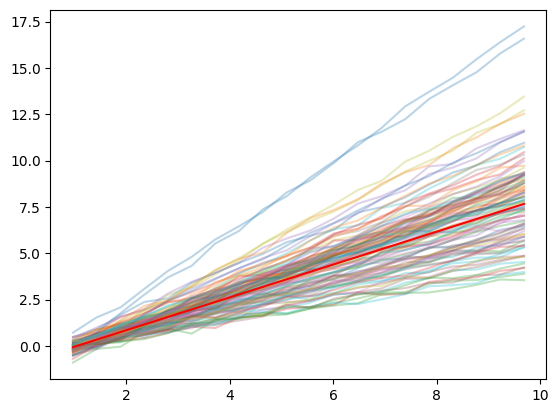

In [7]:
theta = generate_theta()
d, y, t, z = generate_data(theta)
plt.plot(t, np.transpose(y), alpha=0.3)
plt.plot(t, d, color="red")
plt.show()

### Question 3)

In [8]:
@jit(nopython=True)
def S_func(z, y, t):
    t0 = z[0]
    v0 = z[1]
    xi = z[2::2]
    tau = z[3::2]
    alpha = np.exp(xi)
    dij = d_func(alpha[:, None] * (t[None, :] - t0 - tau[:, None]) + t0, p0, v0, t0)

    return np.array(
        [
            t0,
            v0,
            np.mean(xi**2),
            np.mean(tau**2),
            np.mean((y - dij) ** 2),
            t0**2 / sigma_t0**2 + v0**2 / sigma_v0**2,
        ]
    )


@jit(nopython=True)
def psi_func(theta):
    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma = (
        theta[0],
        theta[1],
        theta[2],
        theta[3],
        theta[4],
    )
    return np.array(
        [
            t0_bar / sigma_t0**2,
            v0_bar / sigma_v0**2,
            -N / (2 * sigma_xi**2),
            -N / (2 * sigma_tau**2),
            -k * N / (2 * sigma**2),
            -1 / 2,
        ]
    )


@jit(nopython=True)
def phi_func(theta):
    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma = (
        theta[0],
        theta[1],
        theta[2],
        theta[3],
        theta[4],
    )
    return (
        1
        / 2
        * (
            t0_bar**2 / sigma_t0**2
            + v0_bar**2 / sigma_v0**2
            + t0_bar**2 / s_t0**2
            + v0_bar**2 / s_v0**2
            + v_xi**2 / sigma_xi**2
            + v_tau**2 / sigma_tau**2
            + v**2 / sigma**2
        )
        - t0_bar * t0_bar_bar / s_t0**2
        - v0_bar * v0_bar_bar / s_v0**2
        + (N + m_xi + 2) * np.log(sigma_xi)
        + (N + m_tau + 2) * np.log(sigma_tau)
        + (k * N + m + 2) * np.log(sigma)
    )


@jit(nopython=True, parallel=True)
def log_pi(z, theta, y, t):
    return -phi_func(theta) + np.dot(S_func(z, y, t), psi_func(theta))

In [9]:
@jit(nopython=True, parallel=True)
def symetric_random_walk_metropolis_hastings(
    z0, theta, y, t, sigma=1, iter=DEFAULT_ITERATIONS
):
    z = [z0]

    for _ in range(iter):
        current = z[-1]
        proposal = current + np.random.normal(0, sigma, (2 + 2 * N))
        log_alpha = min(0, log_pi(proposal, theta, y, t) - log_pi(current, theta, y, t))

        if np.log(np.random.rand()) < log_alpha:
            z.append(proposal)
        else:
            z.append(current)

    return z[-1]

### Question 4)

On a montré les formules suivantes :
$$\boxed{\bar{t_0}=\frac{\sigma_{t_0}^2\bar{\bar{t_0}}+s_{t_0}^2S_1}{\sigma_{t_0}^2+s_{t_0}^2} }\quad
\boxed{\bar{v_0}=\frac{\sigma_{v_0}^2\bar{\bar{v_0}}+s_{v_0}^2S_2}{\sigma_{v_0}^2+s_{v_0}^2} }\quad
\boxed{\sigma_\xi^2=\frac{v_\xi^2+NS_3}{N+m_\xi+2} }\quad
\boxed{\sigma_\tau^2=\frac{v_\tau^2+NS_4}{N+m_\tau+2} }\quad
\boxed{\sigma^2=\frac{v^2+NS_5}{kN+m+2} }$$

In [10]:
@jit(nopython=True)
def epsilon_func(i, Nb=100, alpha=0.75):
    if i <= Nb:
        return 1
    else:
        return (i - Nb) ** (-alpha)


@jit(nopython=True, parallel=True)
def stochastic_approximation_em(
    y,
    t,
    theta,
    z=np.zeros((2 + 2 * N)),
    iter=DEFAULT_ITERATIONS,
    sampler=symetric_random_walk_metropolis_hastings,
    sigma=1,
):
    S = np.zeros((6))
    ll = np.zeros((iter))
    successive_values = np.zeros((iter + 1, len(theta)))
    successive_values[0, :] = theta
    for i in range(iter):
        # Simulation
        z = sampler(z, theta, y, t, sigma=sigma)
        # Approximation
        epsilon = epsilon_func(i, Nb=iter // 10)
        S = (1 - epsilon) * S + epsilon * S_func(z, y, t)
        # Maximization
        theta[0] = (sigma_t0**2 * t0_bar_bar + s_t0**2 * S[0]) / (
            sigma_t0**2 + s_t0**2
        )
        theta[1] = (sigma_v0**2 * v0_bar_bar + s_v0**2 * S[1]) / (
            sigma_v0**2 + s_v0**2
        )
        theta[2] = np.sqrt((v_xi**2 + N * S[2]) / (N + m_xi + 2))
        theta[3] = np.sqrt((v_tau**2 + N * S[3]) / (N + m_tau + 2))
        theta[4] = np.sqrt((v**2 + N * S[4]) / (k * N + m + 2))
        # Log-likelihood
        ll[i] = log_pi(z, theta, y, t)
        successive_values[i + 1, :] = theta

    return successive_values, ll

In [11]:
def plot_results(sampler, theta0, sigma, iter):
    estimated_thetas, ll = stochastic_approximation_em(
        y, t, theta0, sampler=sampler, iter=iter, sigma=sigma
    )

    n_plots = 1 + len(theta0)
    _, axs = plt.subplots(2, n_plots // 2, figsize=(24, 10))

    axs[0, 0].plot(ll, label="Log-likelihood")
    axs[0, 0].set_xlabel("Iterations")
    axs[0, 0].set_ylabel("Log-likelihood")

    labels = ["t0", "v0", "sigma_xi", "sigma_tau", "sigma"]
    for i, ax in enumerate(axs.reshape(-1)[1:]):
        ax.plot(estimated_thetas[:, i], label=labels[i])
        ax.hlines(
            theta[i],
            0,
            len(estimated_thetas),
            label="Target",
            color="red",
            linestyles="dashed",
        )
        ax.set_ylim(0, 2)
        ax.set_xlabel("Iterations")
        ax.legend()

    plt.show()

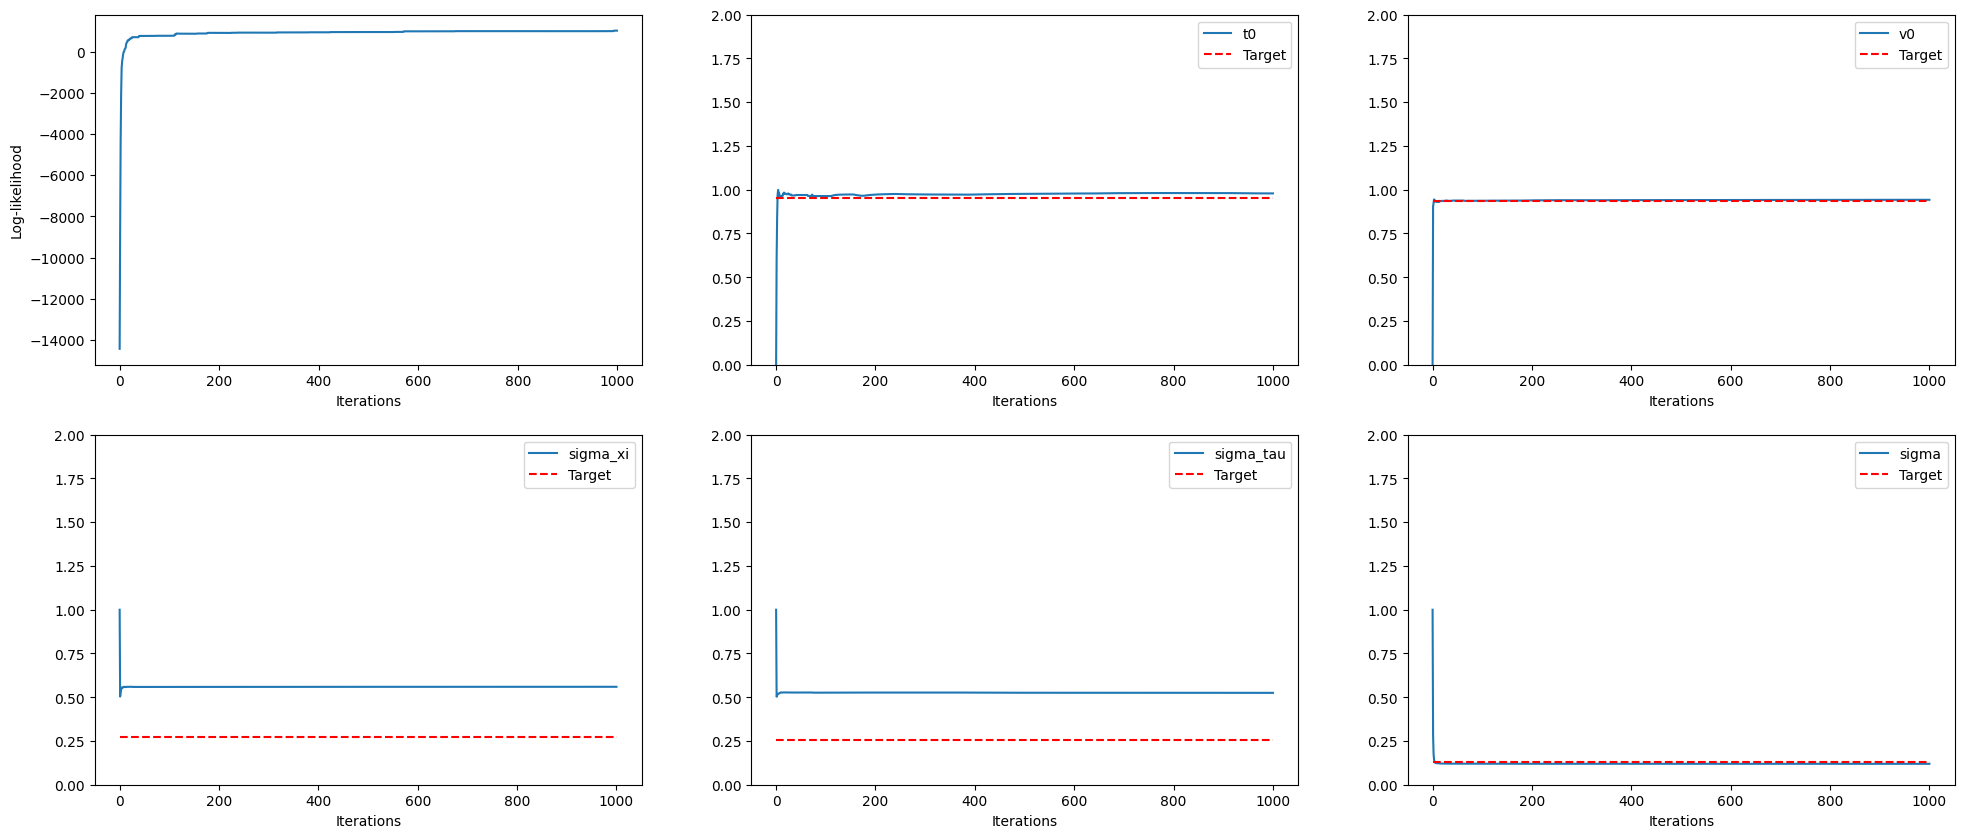

In [12]:
plot_results(symetric_random_walk_metropolis_hastings, theta0, 0.01, 1000)

If $\sigma$ is too big, there are sudden jumps in the likelihood, followed by decreases. This is because the MCMC is suffering from the curse of dimensionality. Sometimes it finds a good value by luck and it goes there, but most of the time it doesn't move. We get better results by decreasing $\sigma$ but the convergence is slow. We also have to consider the size of the dataset that is pretty small in our case. Thus we expect $\theta$ to converge to a value that differ a bit from the true value.

### Question 7)

In [13]:
@jit(nopython=True)
def metropolis_hastings_within_gibbs(z, theta, y, t, sigma=1, iter=50):
    for i in range(len(z)):
        for _ in range(iter):
            proposal = np.copy(z)
            proposal[i] = np.random.normal(proposal[i], sigma)
            log_alpha = min(0, log_pi(proposal, theta, y, t) - log_pi(z, theta, y, t))
            if np.log(np.random.random()) < log_alpha:
                z = proposal
    return z

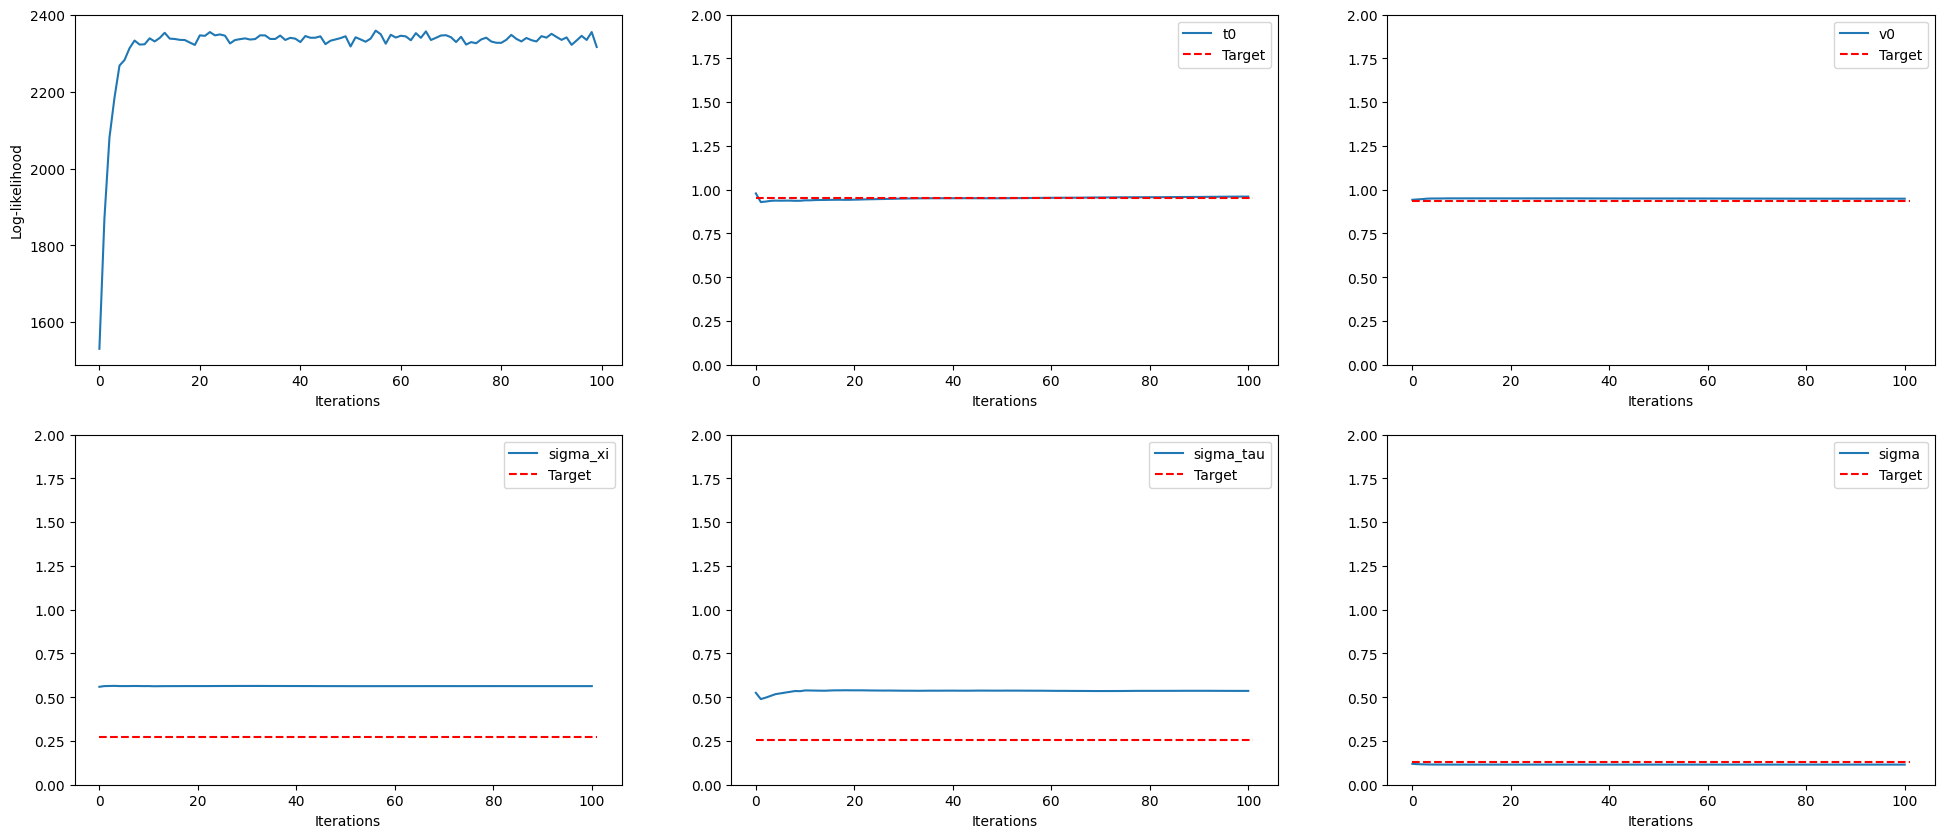

In [14]:
plot_results(metropolis_hastings_within_gibbs, theta0, 0.1, 100)

### Question 9)

In [15]:
@jit(nopython=True)
def block_metropolis_hastings_within_gibbs(z, theta, y, t, sigma=1, iter=50):
    for i in range(len(z) // 2):
        for _ in range(iter):
            proposal = np.copy(z)
            proposal[2 * i : 2 * i + 2] += np.random.normal(0, sigma, (2))
            log_alpha = min(0, log_pi(proposal, theta, y, t) - log_pi(z, theta, y, t))
            if np.log(np.random.random()) < log_alpha:
                z = proposal

    return z

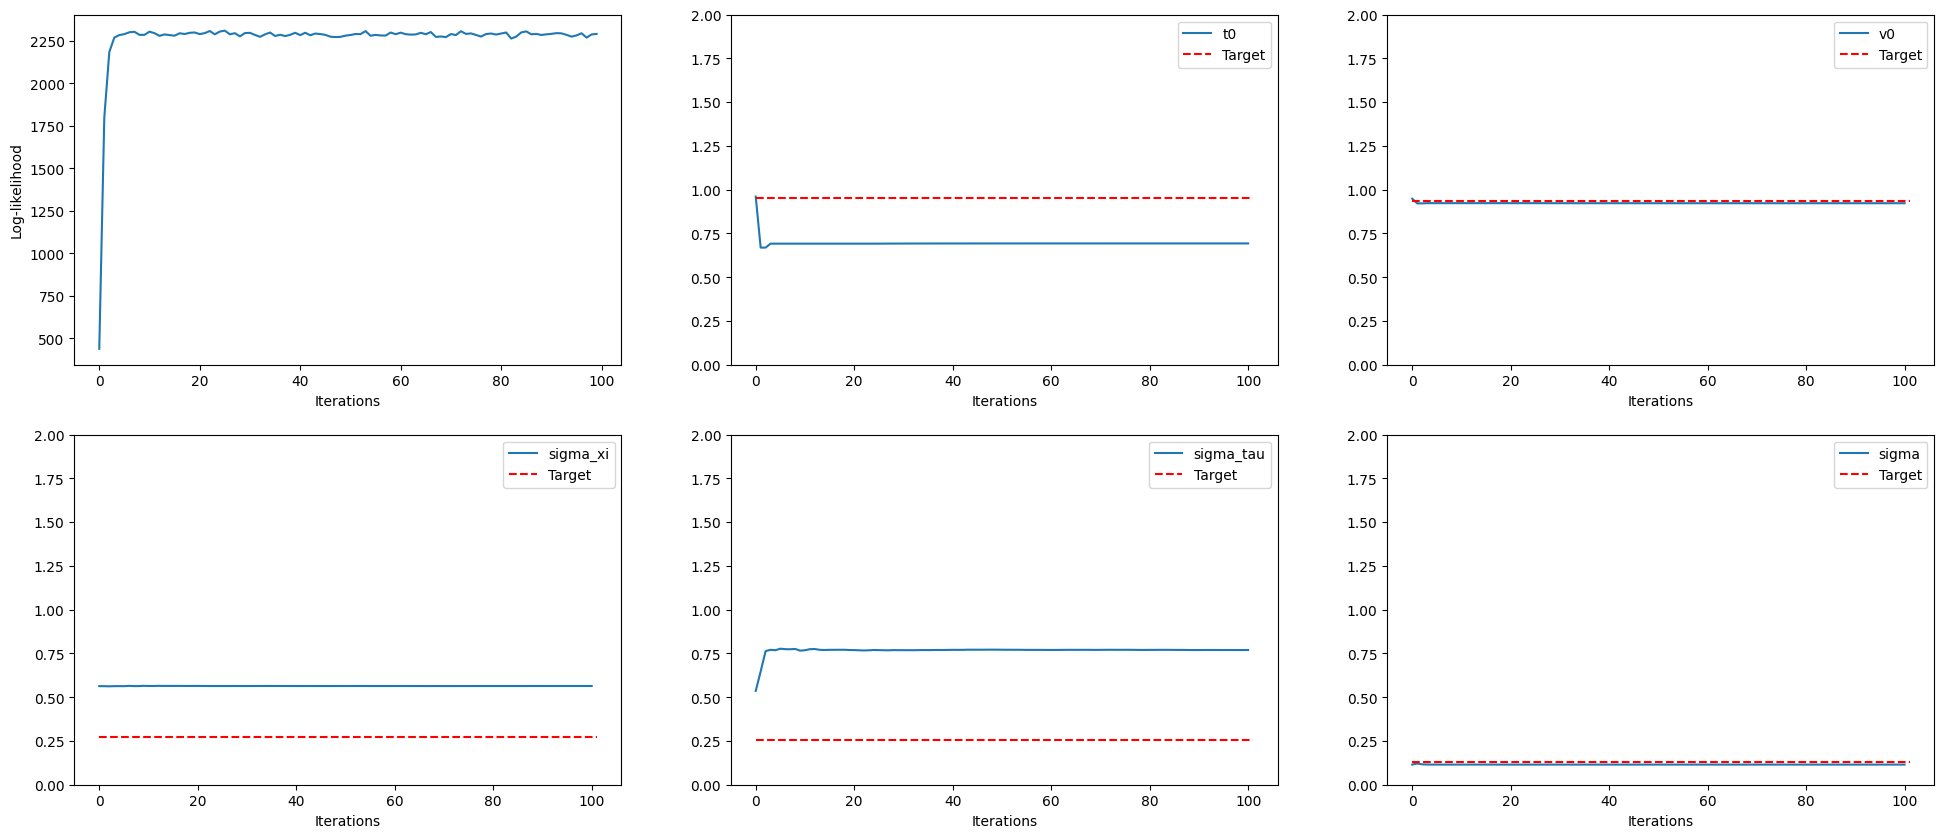

In [16]:
plot_results(block_metropolis_hastings_within_gibbs, theta0, 0.1, 100)

## Exercise 2: Multiplicative Hasting-Metropolis

### Question 3)

In [17]:
def multiplicative_hastings_metropolis(pi, x0, f, iter=DEFAULT_ITERATIONS):
    x = [x0]
    for _ in range(iter):
        current = x[-1]
        B = np.random.choice([0, 1])
        epsilon = f()
        if B == 1:
            proposal = current * epsilon
        else:
            proposal = current / epsilon

        alpha = min(1, pi(proposal) / pi(current))
        if np.random.rand() < alpha:
            x.append(proposal)
    return x


N = 1000

### Gamma distribution

Acceptance rate: 0.4826600000000008


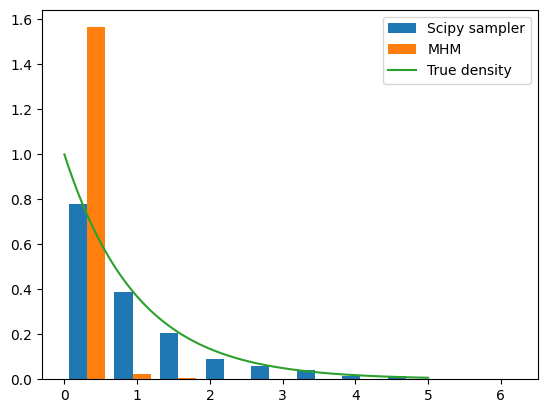

In [18]:
sampled = sp.stats.gamma.rvs(a=1, scale=1, size=N)
pi = sp.stats.gamma(a=1, scale=1).pdf


def uniform_minus_one_plus_one():
    return (np.random.rand() - 0.5) * 2


mhm_samples = []
acceptance = 0
for _ in range(N):
    samples = multiplicative_hastings_metropolis(pi, 1, uniform_minus_one_plus_one)
    mhm_samples.append(samples[-1])
    acceptance += len(samples) / DEFAULT_ITERATIONS
acceptance /= N
print("Acceptance rate:", acceptance)

plt.hist(
    [sampled, mhm_samples],
    density=True,
    label=["Scipy sampler", "MHM"],
)
plt.plot(np.linspace(0, 5, 100), pi(np.linspace(0, 5, 100)), label="True density")
plt.legend()
plt.show()

### Normal distribution

Acceptance rate: 0.9765920000000028


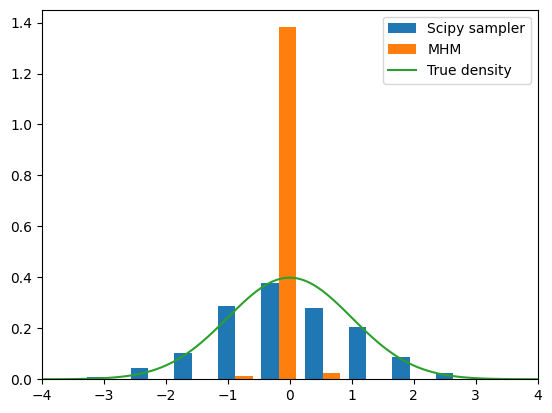

In [19]:
sampled = sp.stats.norm.rvs(size=N)
pi = sp.stats.norm().pdf

mhm_samples = []
acceptance = 0
for _ in range(N):
    samples = multiplicative_hastings_metropolis(pi, 1, uniform_minus_one_plus_one)
    mhm_samples.append(samples[-1])
    acceptance += len(samples) / DEFAULT_ITERATIONS
acceptance /= N
print("Acceptance rate:", acceptance)

plt.hist(
    [sampled, mhm_samples],
    density=True,
    label=["Scipy sampler", "MHM"],
)
plt.plot(np.linspace(-4, 4, 100), pi(np.linspace(-4, 4, 100)), label="True density")
plt.legend()
plt.xlim(-4, 4)
plt.show()

Those results are quite bad, in particular there are too many samples near $0$. We can try another proposal distribution $f$ that does fewer "extreme jumps" by removing the $[-0.25, 0.25]$ interval.

### Gamma distribution

Acceptance rate: 0.4801360000000003


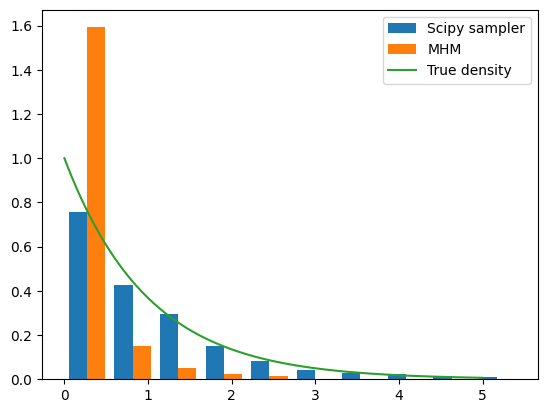

In [20]:
sampled = sp.stats.gamma.rvs(a=1, scale=1, size=N)
pi = sp.stats.gamma(a=1, scale=1).pdf


def modified_uniform(lim=0.75):
    assert 0 < lim < 1
    epsilon = (np.random.rand() - 0.5) * 2
    if abs(epsilon) < lim:
        # We rescale the uniform distribution to be between lim and 1
        scaled = (1 - lim) * abs(epsilon) + lim
        # We make it uniform on the positive and negative side
        epsilon += (epsilon < 0) * (-scaled) + (epsilon > 0) * scaled
    return epsilon


mhm_samples = []
acceptance = 0
for _ in range(N):
    samples = multiplicative_hastings_metropolis(pi, 1, modified_uniform)
    mhm_samples.append(samples[-1])
    acceptance += len(samples) / DEFAULT_ITERATIONS
acceptance /= N
print("Acceptance rate:", acceptance)

plt.hist(
    [sampled, mhm_samples],
    density=True,
    label=["Scipy sampler", "MHM"],
)
plt.plot(np.linspace(0, 5, 100), pi(np.linspace(0, 5, 100)), label="True density")
plt.legend()
plt.show()

### Normal distribution

Acceptance rate: 0.9730080000000012


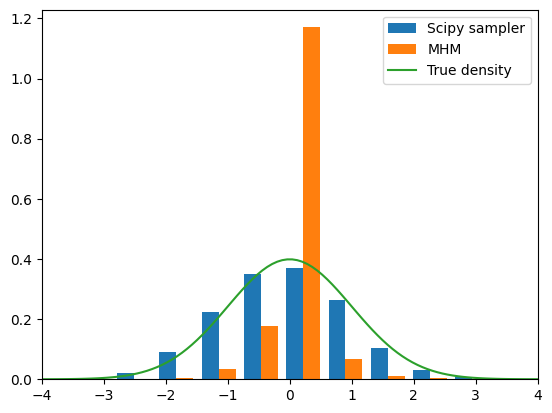

In [21]:
sampled = sp.stats.norm.rvs(size=N)
pi = sp.stats.norm().pdf

mhm_samples = []
acceptance = 0
for _ in range(N):
    samples = multiplicative_hastings_metropolis(pi, 1, modified_uniform)
    mhm_samples.append(samples[-1])
    acceptance += len(samples) / DEFAULT_ITERATIONS
acceptance /= N
print("Acceptance rate:", acceptance)

plt.hist(
    [sampled, mhm_samples],
    density=True,
    label=["Scipy sampler", "MHM"],
)
plt.plot(np.linspace(-4, 4, 100), pi(np.linspace(-4, 4, 100)), label="True density")
plt.legend()
plt.xlim(-4, 4)
plt.show()

Those results are a bit better. However this method is not very good because it is very sensitive to the distribution $f$. If we choose a bad $f$, we can get very bad results. Yet this distribution is hard to choose because it doesn't intervene in the acceptance rate.